Text(0.5, 1.0, 'X vs y')

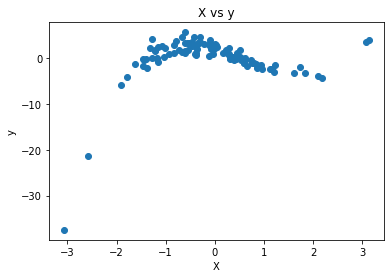

In [119]:
import numpy as np
import pandas as pd

mu, sigma = 0, 1
n = 100
X = np.random.normal(mu, sigma, n)
noise = np.random.normal(mu, sigma, n)

y = 2 -3*X -2*pow(X, 2) + pow(X, 3) + noise

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("y")
plt.title("X vs y")

In [129]:
from sklearn.preprocessing import scale, StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

import itertools
from itertools import combinations

# we could also use Exhaustive Feature Selector from mlxtend
# http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/
def best_subset_func(estimator, X, y, max_size=10, cv=5):
    n_features = X.shape[1]
    subsets = (combinations(range(n_features), k + 1) for k in range(min(n_features, max_size)))

    best_size_subset = []
    for subsets_k in subsets:  # for each list of subsets of the same size
        best_score = -np.inf
        best_subset = None
        for subset in subsets_k: # for each subset
            estimator.fit(X.iloc[:, list(subset)], y)
            # get the subset with the best score among subsets of the same size
            score = estimator.score(X.iloc[:, list(subset)], y)
            if score > best_score:
                best_score, best_subset = score, subset
        # to compare subsets of different sizes we must use CV
        # first store the best subset of each size
        best_size_subset.append(best_subset)

    return best_size_subset

In [225]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
import statsmodels.api as sm

predictors = pd.DataFrame(X, columns=['X'])
predictors['X^2'] = pow(X,2)
predictors['X^3'] = pow(X,3)
predictors['X^4'] = pow(X,4)
predictors['X^5'] = pow(X,5)
predictors['X^6'] = pow(X,6)
predictors['X^7'] = pow(X,7)
predictors['X^8'] = pow(X,8)
predictors['X^9'] = pow(X,9)
predictors['X^10'] = pow(X,10)

lm = LinearRegression()

best_size_subset = best_subset_func(lm, predictors, y, max_size=10, cv=5)


In [131]:
import math

#first evaluate best model with Cp
# compare best subsets of each size
def calculate_best_score(estimator, X, y, best_size_subset, method = "Cp", stepwise=False):
  best_score = np.inf
  if method == 'adjustedR2':
    best_score = -np.inf

  best_subset = None
  list_scores = []

  i = 1
  for subset in best_size_subset:
    # we need RSS
    if stepwise:
      predictions = estimator.fit(X[list(subset['feature_names'])], y).predict(X[list(subset['feature_names'])])
    else:
      predictions = estimator.fit(X.iloc[:, list(subset)], y).predict(X.iloc[:, list(subset)])

    RSS = n * mean_squared_error(y, predictions)

    #we need estimate of the variance of the error (we know it is 1, but we should estimate it)
    #this is apparenlty RSS / (n-p)
    estStd = math.sqrt(RSS / (n - i))

    if method == "Cp":
      score = (RSS + 2*i*estStd) / n
    elif method == "BIC":
      score = (RSS + math.log(n)*i*estStd) / n
    else:
      #we need TSS for adjusted R2
      m = y.mean()
      TSS = 0
      for i in y:
        TSS += ((i-m)**2)
      
      score =  1 - (RSS / (n - i - 1)) / (TSS / (n-1)) 

    if method == "adjustedR2":
      if score > best_score:
        best_score, best_subset = score, subset
    else:
      if score < best_score:
        best_score, best_subset = score, subset
    
    list_scores.append(score)
    i = i + 1
  
  return best_subset, best_score, list_scores


[(0, 1, 2, 3), 1.2494892460022253]
[1.9154183085793952, array([-3.00239904, -1.77720647,  1.02590593, -0.02854208])]


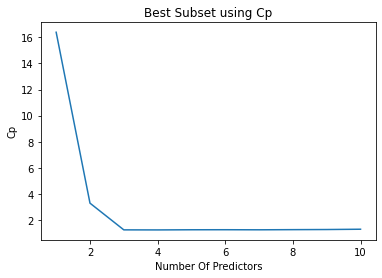

In [226]:
#first evaluate best model with Cp

best_subset, best_score, list_scores = calculate_best_score(lm, predictors, y, best_size_subset, method="Cp")

plt.plot(np.arange(1,11), list_scores)
plt.ylabel("Cp")
plt.xlabel("Number Of Predictors")
plt.title("Best Subset using Cp")

print([best_subset, best_score])
bestFit = lm.fit(predictors.iloc[:, list(best_subset)], y)
print([bestFit.intercept_, bestFit.coef_])


[(0, 1, 2), 1.3399326878705602]
[2.037227598621563, array([-3.01703668, -2.00523335,  1.02136414])]


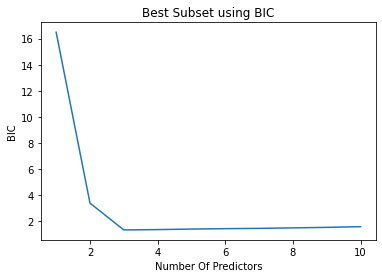

In [227]:
#next evaluate using BIC

best_subset, best_score, list_scores = calculate_best_score(lm, predictors, y, best_size_subset, method="BIC")

plt.plot(np.arange(1,11), list_scores)
plt.ylabel("BIC")
plt.xlabel("Number Of Predictors")
plt.title("Best Subset using BIC")

print([best_subset, best_score])
bestFit = lm.fit(predictors.iloc[:, list(best_subset)], y)
print([bestFit.intercept_, bestFit.coef_])

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 0.9534343825009517]
[2.1939089512687406, array([-3.08995163e+00, -3.74523556e+00,  1.28936699e+00,  2.06788457e+00,
       -7.43233306e-02, -6.96725942e-01,  6.63999960e-04,  8.80098151e-02,
        4.70264447e-04, -3.75301283e-03])]


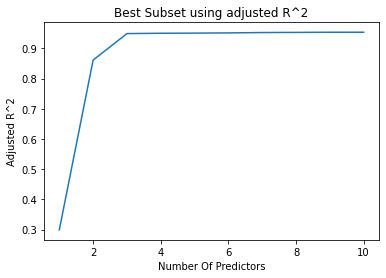

In [229]:
# finally using adjusted R2

best_subset, best_score, list_scores = calculate_best_score(lm, predictors, y, best_size_subset, method="adjustedR2")

plt.plot(np.arange(1,11), list_scores)
plt.ylabel("Adjusted R^2")
plt.xlabel("Number Of Predictors")
plt.title("Best Subset using adjusted R^2")

print([best_subset, best_score])
bestFit = lm.fit(predictors.iloc[:, list(best_subset)], y)
print([bestFit.intercept_, bestFit.coef_])

In [231]:
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(lm, 
           k_features=10, 
           forward=True, 
           floating=False, 
           cv=0)

sfs1 = sfs1.fit(predictors, y)

[{'feature_idx': (0, 1, 2, 3, 4), 'cv_scores': array([0.95214303]), 'avg_score': 0.9521430282220351, 'feature_names': ('X', 'X^2', 'X^3', 'X^4', 'X^5')}, 1.2689157254433767]
[1.9124384716086256, array([-2.90069485, -1.76702905,  0.95330166, -0.03046272,  0.00696324])]


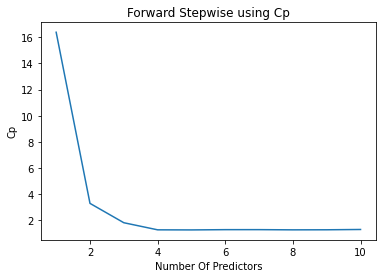

In [232]:
#due to some inner workings we need to convert to a list
best_size_subset = []
for i in range (1,11):
  best_size_subset.append(sfs1.subsets_[i])

#evaluate forward-selection using Cp
best_subset, best_score, list_scores = calculate_best_score(lm, predictors, y, best_size_subset, method="Cp", stepwise=True)

plt.plot(np.arange(1,11), list_scores)
plt.ylabel("Cp")
plt.xlabel("Number Of Predictors")
plt.title("Forward Stepwise using Cp")

print([best_subset, best_score])
bestFit = lm.fit(predictors[list(best_subset['feature_names'])], y)
print([bestFit.intercept_, bestFit.coef_])



[{'feature_idx': (0, 1, 2, 4), 'cv_scores': array([0.95098293]), 'avg_score': 0.9509829291915105, 'feature_names': ('X', 'X^2', 'X^3', 'X^5')}, 1.3913631309898873]
[2.039372365676964, array([-2.97562905e+00, -2.00735755e+00,  9.91389463e-01,  2.86272407e-03])]


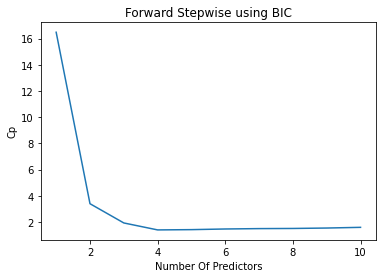

In [207]:
#evaluate forward-selection using BIC
best_subset, best_score, list_scores = calculate_best_score(lm, predictors, y, best_size_subset, method="BIC", stepwise=True)

plt.plot(np.arange(1,11), list_scores)
plt.ylabel("Cp")
plt.xlabel("Number Of Predictors")
plt.title("Forward Stepwise using BIC")

print([best_subset, best_score])
bestFit = lm.fit(predictors[list(best_subset['feature_names'])], y)
print([bestFit.intercept_, bestFit.coef_])

[{'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 'cv_scores': array([0.95526316]), 'avg_score': 0.9552631625757855, 'feature_names': ('X', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10')}, 0.9534343825009517]
[2.1939089512687406, array([-3.08995163e+00, -3.74523556e+00,  1.28936699e+00,  2.06788457e+00,
       -7.43233306e-02, -6.96725942e-01,  6.63999960e-04,  8.80098151e-02,
        4.70264447e-04, -3.75301283e-03])]


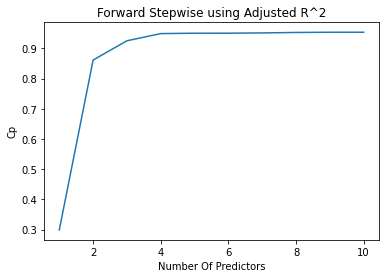

In [208]:
#evaluate forward-selection using adjusted R^2
best_subset, best_score, list_scores = calculate_best_score(lm, predictors, y, best_size_subset, method="adjustedR2", stepwise=True)

plt.plot(np.arange(1,11), list_scores)
plt.ylabel("Cp")
plt.xlabel("Number Of Predictors")
plt.title("Forward Stepwise using Adjusted R^2")

print([best_subset, best_score])
bestFit = lm.fit(predictors[list(best_subset['feature_names'])], y)
print([bestFit.intercept_, bestFit.coef_])

In [209]:
sfs2 = SFS(lm, 
           k_features=1, 
           forward=False, 
           floating=False,
           cv=0
           )

sfs2 = sfs2.fit(predictors.values, y, custom_feature_names=predictors.columns)



In [41]:
sfs2.subsets_

{1: {'avg_score': 0.7124022283771307,
  'cv_scores': array([0.71240223]),
  'feature_idx': (3,),
  'feature_names': ('X^4',)},
 2: {'avg_score': 0.8082868688075471,
  'cv_scores': array([0.80828687]),
  'feature_idx': (0, 3),
  'feature_names': ('X', 'X^4')},
 3: {'avg_score': 0.8479968888035941,
  'cv_scores': array([0.84799689]),
  'feature_idx': (0, 2, 3),
  'feature_names': ('X', 'X^3', 'X^4')},
 4: {'avg_score': 0.8979984940754261,
  'cv_scores': array([0.89799849]),
  'feature_idx': (0, 2, 3, 5),
  'feature_names': ('X', 'X^3', 'X^4', 'X^6')},
 5: {'avg_score': 0.9211702873650766,
  'cv_scores': array([0.92117029]),
  'feature_idx': (0, 2, 3, 5, 7),
  'feature_names': ('X', 'X^3', 'X^4', 'X^6', 'X^8')},
 6: {'avg_score': 0.925564702419432,
  'cv_scores': array([0.9255647]),
  'feature_idx': (0, 2, 3, 5, 7, 9),
  'feature_names': ('X', 'X^3', 'X^4', 'X^6', 'X^8', 'X^10')},
 7: {'avg_score': 0.9256742338478715,
  'cv_scores': array([0.92567423]),
  'feature_idx': (0, 2, 3, 5, 7, 8,

[{'feature_idx': (0, 1, 2, 5), 'cv_scores': array([0.9519389]), 'avg_score': 0.9519389008888043, 'feature_names': ('X', 'X^2', 'X^3', 'X^6')}, 1.2514971609893002]
[1.9400523014177835, array([-3.01315533e+00, -1.85546596e+00,  1.02807143e+00, -2.17369276e-03])]


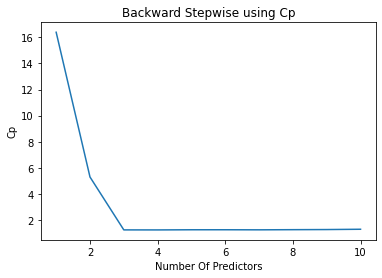

In [210]:
#due to some inner workings we need to convert to a list
best_size_subset = []
for i in range (1, 11):
  best_size_subset.append(sfs2.subsets_[i])

#evaluate backward-selection using Cp
best_subset, best_score, list_scores = calculate_best_score(lm, predictors, y, best_size_subset, method="Cp", stepwise=True)

plt.plot(np.arange(1,11), list_scores)
plt.ylabel("Cp")
plt.xlabel("Number Of Predictors")
plt.title("Backward Stepwise using Cp")

print([best_subset, best_score])
bestFit = lm.fit(predictors[list(best_subset['feature_names'])], y)
print([bestFit.intercept_, bestFit.coef_])

[{'feature_idx': (0, 1, 2), 'cv_scores': array([0.95096113]), 'avg_score': 0.9509611263680984, 'feature_names': ('X', 'X^2', 'X^3')}, 1.3399326878705602]
[2.037227598621563, array([-3.01703668, -2.00523335,  1.02136414])]


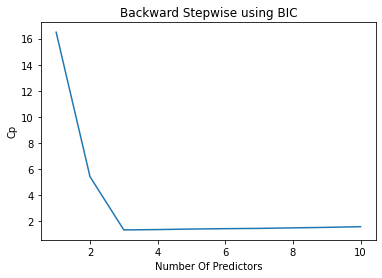

In [211]:
#evaluate backward-selection using BIC
best_subset, best_score, list_scores = calculate_best_score(lm, predictors, y, best_size_subset, method="BIC", stepwise=True)

plt.plot(np.arange(1,11), list_scores)
plt.ylabel("Cp")
plt.xlabel("Number Of Predictors")
plt.title("Backward Stepwise using BIC")

print([best_subset, best_score])
bestFit = lm.fit(predictors[list(best_subset['feature_names'])], y)
print([bestFit.intercept_, bestFit.coef_])

[{'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 'cv_scores': array([0.95526316]), 'avg_score': 0.9552631625757855, 'feature_names': ('X', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10')}, 0.9534343825009517]
[2.1939089512687406, array([-3.08995163e+00, -3.74523556e+00,  1.28936699e+00,  2.06788457e+00,
       -7.43233306e-02, -6.96725942e-01,  6.63999960e-04,  8.80098151e-02,
        4.70264447e-04, -3.75301283e-03])]


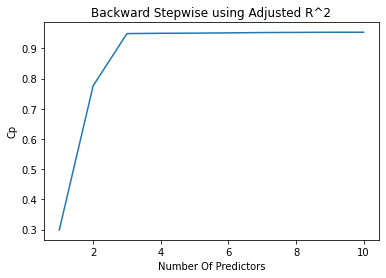

In [212]:
#evaluate backward-selection using adjusted R^2
best_subset, best_score, list_scores = calculate_best_score(lm, predictors, y, best_size_subset, method="adjustedR2", stepwise=True)

plt.plot(np.arange(1,11), list_scores)
plt.ylabel("Cp")
plt.xlabel("Number Of Predictors")
plt.title("Backward Stepwise using Adjusted R^2")

print([best_subset, best_score])
bestFit = lm.fit(predictors[list(best_subset['feature_names'])], y)
print([bestFit.intercept_, bestFit.coef_])

In [213]:
from sklearn.model_selection import KFold
from sklearn import linear_model

def select_best_lambda(X, y, k = 10, lambdaMax = 50, lambdaStep = 0.1):
  cv_scores = []
  best_score = np.inf
  best_lambda = 0;
  n = X.shape[0]

  for a in np.arange(0, lambdaMax, lambdaStep):
    lasso = linear_model.Lasso(alpha=a)
    kf = KFold(n_splits=k)
    sumCV = 0
    for train_indices, test_indices in kf.split(X, y):
      fitted = lasso.fit(X.loc[train_indices], y[train_indices])
      numPredictors = np.count_nonzero(fitted.coef_)
      # we need RSS
      predictions = fitted.predict(X.loc[test_indices])
      RSS = n * mean_squared_error(y[test_indices], predictions)

      #we need estimate of the variance of the error (we know it is 1, but we should estimate it)
      #this is apparenlty RSS / (n-p)
      estStd = math.sqrt(RSS / (n - numPredictors))
      #Use BIC
      score = (RSS + math.log(n)*numPredictors*estStd) / n
      sumCV = sumCV + score

    CV = sumCV / k
    if CV < best_score:
      best_score, best_lambda = CV, a

    cv_scores.append(CV)
  
  return best_lambda, best_score, cv_scores, lambdaMax, lambdaStep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.302e+01, tolerance: 2.382e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_re

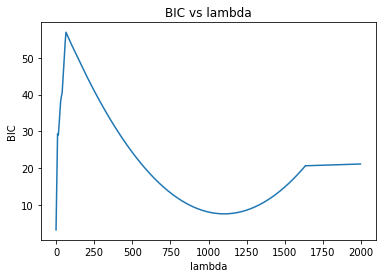

In [224]:
from sklearn.model_selection import KFold
from sklearn import linear_model

best_lambda, best_score, cv_scores, lambdaMax, lambdaStep = select_best_lambda(predictors, y, lambdaStep=5, lambdaMax=2000)

plt.title("BIC vs lambda")
plt.xlabel("lambda")
plt.ylabel("BIC")
plt.plot(np.arange(0, lambdaMax, lambdaStep), cv_scores)



In [215]:
fittedFull = linear_model.Lasso(alpha=best_lambda).fit(predictors, y)
print(fittedFull.coef_)
print(fittedFull.intercept_)


[-1.65494916e+00 -1.32114913e+00  0.00000000e+00 -8.16940157e-02
  1.73281124e-01 -1.17679733e-02 -4.28962318e-03  7.33806384e-04
 -4.43271731e-04  6.50718036e-05]
1.7089692097749558


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.297e+01, tolerance: 2.421e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [216]:
print(best_lambda)


0.1


Text(0.5, 1.0, 'X vs y')

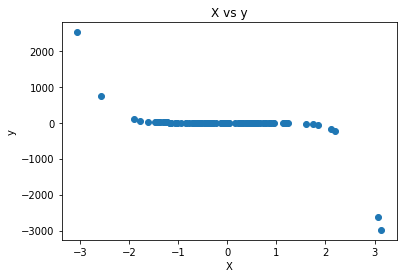

In [217]:
yPrime = 2 - pow(X,7) + noise

plt.scatter(X, yPrime)
plt.xlabel("X")
plt.ylabel("y")
plt.title("X vs y")


[(6,), 1.2377944380711798]
[-0.008870002240835062, array([0.00569308])]


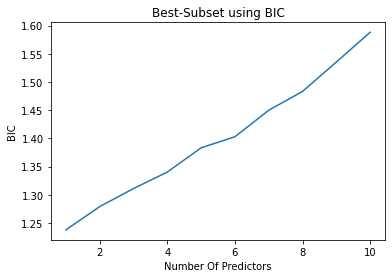

In [218]:
best_size_subset = best_subset_func(lm, predictors, yPrime, max_size=10, cv=5)

best_subset, best_score, list_scores = calculate_best_score(lm, predictors, yPrime, best_size_subset, method="BIC")

plt.plot(np.arange(1,11), list_scores)
plt.ylabel("BIC")
plt.xlabel("Number Of Predictors")
plt.title("Best-Subset using BIC")

print([best_subset, best_score])
bestFit = lm.fit(predictors.iloc[:, list(best_subset)], y)
print([bestFit.intercept_, bestFit.coef_])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7

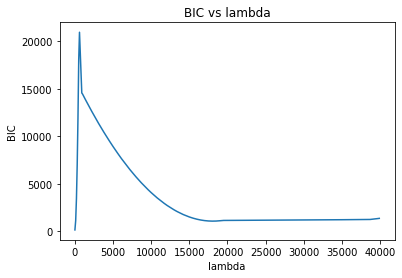

In [222]:
best_lambda, best_score, cv_scores, lambdaMax, lambdaStep = select_best_lambda(predictors, yPrime, lambdaMax=40000, lambdaStep=100)

plt.title("BIC vs lambda")
plt.xlabel("lambda")
plt.ylabel("BIC")
plt.plot(np.arange(0, lambdaMax, lambdaStep), cv_scores)



In [223]:
fittedFull = linear_model.Lasso(alpha=best_lambda).fit(predictors, yPrime)
print(fittedFull.coef_)
print(fittedFull.intercept_)


[-6.79501531e+00  6.85667462e-01  1.15347087e+01  6.52983485e-01
 -4.54386338e+00 -1.94350370e-01 -3.83595052e-01  1.58513519e-03
 -2.71812133e-02  1.13954867e-03]
1.6179938580208244


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


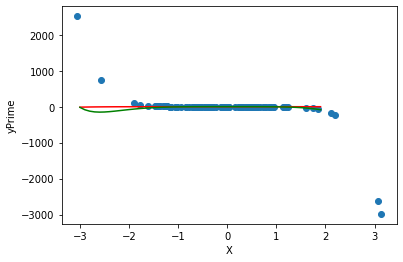

In [221]:
plt.ylabel("yPrime")
plt.xlabel("X")

plt.scatter(X, yPrime)

x = np.arange(-3, 2, 0.1)
yBest = bestFit.intercept_ + bestFit.coef_ * pow(x,7)
plt.plot(x, yBest, 'r')

yLasso = fittedFull.intercept_ + fittedFull.coef_[3]*pow(x,3) + fittedFull.coef_[4]*pow(x,4) + fittedFull.coef_[5]*pow(x,5) + fittedFull.coef_[6]*pow(x,6) + fittedFull.coef_[7]*pow(x,7) + fittedFull.coef_[8]*pow(x,9) + fittedFull.coef_[9]*pow(x,10)
plt.plot(x, yLasso, 'g')


array([0.02904566])